# TrafficDemandModel Demonstration

This notebook demonstrates the direct usage of the `TrafficDemandModel` from the `radp.digital_twin.utils.traffic_demand_simulation` module. The `TrafficDemandModel` is responsible for generating User Equipment (UE) distributions over a simulated geographical area based on cell tower locations, defined spatial characteristics (e.g., residential, commercial areas), and time-varying demand profiles.

**Key functionalities showcased:**
1. Setting up a sample network topology.
2. Defining spatial parameters (area types and their proportions).
3. Defining temporal parameters (simulation duration and UE density weights per area type per tick).
4. Instantiating and running the `TrafficDemandModel`.
5. Inspecting the generated outputs: per-tick UE data and the fixed spatial layout.
6. Basic visualization of UE distribution for a selected tick.

## 1. Setup and Imports

First, we need to import necessary libraries and the `TrafficDemandModel` itself. Ensure that the `radp` library is accessible in your Python environment (e.g., by setting `PYTHONPATH` to include the `MAVERIC_ROOT` directory or by installing `radp`).

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import json
import logging

# Setup logging for better output
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger("NotebookDemo")

# --- Add MAVERIC_ROOT to Python path if radp is not installed ---
# Adjust this path if your notebook is located elsewhere relative to the project root.
MAVERIC_ROOT = os.path.abspath(os.path.join(os.getcwd(), "..")) # Assumes notebook is in maveric/notebooks/
if MAVERIC_ROOT not in sys.path:
    sys.path.insert(0, MAVERIC_ROOT)
logger.info(f"MAVERIC_ROOT considered as: {MAVERIC_ROOT}")
logger.info(f"PYTHONPATH: {sys.path}")

try:
    from radp.digital_twin.utils.traffic_demand_simulation import TrafficDemandModel
    from radp.digital_twin.utils import constants as c # For column names
    logger.info("Successfully imported TrafficDemandModel and constants from RADP.")
except ImportError as e:
    logger.error(f"Failed to import RADP modules: {e}")
    logger.error("Please ensure MAVERIC_ROOT is correctly set and points to the root of your Maveric project.")
    # You might need to restart the kernel after setting PYTHONPATH if it wasn't set before starting Jupyter.

2025-05-23 01:51:49,577 - NotebookDemo - INFO - MAVERIC_ROOT considered as: /home/lk/Projects/accelcq-repos/cloudly/github/maveric
2025-05-23 01:51:49,578 - NotebookDemo - INFO - PYTHONPATH: ['/home/lk/Projects/accelcq-repos/cloudly/github/maveric', '/usr/lib/python39.zip', '/usr/lib/python3.9', '/usr/lib/python3.9/lib-dynload', '', '/home/lk/Projects/accelcq-repos/cloudly/github/maveric/venv/lib/python3.9/site-packages']
2025-05-23 01:51:49,579 - NotebookDemo - INFO - Successfully imported TrafficDemandModel and constants from RADP.


## 2. Define Input Parameters

We need to define:
* A sample `topology_df`: DataFrame containing cell tower locations.
* `spatial_params`: Dictionary defining area types and their proportions.
* `time_params`: Dictionary defining simulation duration and UE density weights.
* `num_ues_per_tick`: The target number of UEs to generate per tick.

In [9]:
# Sample Topology Data (replace with your actual data if needed)
# Ensure column names match what TrafficDemandModel expects (e.g., using radp.constants)
COL_CELL_ID = getattr(c, 'CELL_ID', 'cell_id')
COL_CELL_LAT = getattr(c, 'CELL_LAT', 'cell_lat')
COL_CELL_LON = getattr(c, 'CELL_LON', 'cell_lon')

topology_data = {
    COL_CELL_ID: ['cell_1', 'cell_2', 'cell_3', 'cell_4', 'cell_5', 'cell_6'],
    COL_CELL_LAT: [40.7128, 40.7135, 40.7150, 40.7120, 40.7100, 40.7145], # NYC area latitudes
    COL_CELL_LON: [-74.0060, -74.0050, -74.0070, -74.0080, -74.0040, -74.0030]  # NYC area longitudes
    # Add other columns like cell_az_deg, cell_txpwr_dbm if your model uses them internally,
    # but for basic spatial layout, lat/lon are primary.
}
topology_df = pd.DataFrame(topology_data)
logger.info("Sample Topology DataFrame:")
print(topology_df)

# Spatial Parameters
spatial_params = {
    "types": ["downtown", "residential_uptown", "park_area"],
    "proportions": [0.4, 0.4, 0.2] # Must sum to 1.0
}
logger.info(f"\nSpatial Parameters: {json.dumps(spatial_params, indent=2)}")

# Temporal Parameters
total_ticks_sim = 5 # Simulate for 5 time steps
time_params = {
    "total_ticks": total_ticks_sim,
    "time_weights": { # Relative UE density for each area type per tick
        "downtown":           [0.2, 0.5, 0.8, 0.6, 0.3], # High during mid-ticks (daytime)
        "residential_uptown": [0.6, 0.4, 0.1, 0.3, 0.5], # Higher during early/late ticks (morning/evening)
        "park_area":          [0.2, 0.1, 0.1, 0.1, 0.2]  # Lower, consistent presence
    }
}
logger.info(f"\nTime Parameters: {json.dumps(time_params, indent=2)}")

# Number of UEs per tick
num_ues_per_tick = 200
logger.info(f"\nTarget UEs per tick: {num_ues_per_tick}")

2025-05-23 01:51:49,641 - NotebookDemo - INFO - Sample Topology DataFrame:
2025-05-23 01:51:49,644 - NotebookDemo - INFO - 
Spatial Parameters: {
  "types": [
    "downtown",
    "residential_uptown",
    "park_area"
  ],
  "proportions": [
    0.4,
    0.4,
    0.2
  ]
}
2025-05-23 01:51:49,645 - NotebookDemo - INFO - 
Time Parameters: {
  "total_ticks": 5,
  "time_weights": {
    "downtown": [
      0.2,
      0.5,
      0.8,
      0.6,
      0.3
    ],
    "residential_uptown": [
      0.6,
      0.4,
      0.1,
      0.3,
      0.5
    ],
    "park_area": [
      0.2,
      0.1,
      0.1,
      0.1,
      0.2
    ]
  }
}
2025-05-23 01:51:49,645 - NotebookDemo - INFO - 
Target UEs per tick: 200


  cell_id  cell_lat  cell_lon
0  cell_1   40.7128   -74.006
1  cell_2   40.7135   -74.005
2  cell_3   40.7150   -74.007
3  cell_4   40.7120   -74.008
4  cell_5   40.7100   -74.004
5  cell_6   40.7145   -74.003


## 3. Instantiate and Run TrafficDemandModel

In [10]:
traffic_model_instance = TrafficDemandModel()

logger.info("Running TrafficDemandModel.generate_traffic_demand()...")
ue_data_per_tick_output, spatial_layout_output = traffic_model_instance.generate_traffic_demand(
    topology_df=topology_df,
    spatial_params=spatial_params,
    time_params=time_params,
    num_ues_per_tick=num_ues_per_tick
)

logger.info("Traffic demand generation complete.")

2025-05-23 01:51:49,652 - NotebookDemo - INFO - Running TrafficDemandModel.generate_traffic_demand()...
[2025-05-23 01:51:49,653] INFO:  Starting traffic demand generation process...
[2025-05-23 01:51:49,653] INFO:  Generating fixed spatial layout...
[2025-05-23 01:51:49,655] INFO:  Voronoi processing: Regions processed=2, Infinite skipped=5, Invalid/Empty skipped=0
[2025-05-23 01:51:49,655] INFO:  Generated 2 spatial cells for the fixed layout.
[2025-05-23 01:51:49,747] INFO:  Finished UE distribution for 5 ticks.
[2025-05-23 01:51:49,748] INFO:  Traffic demand generation process completed.
2025-05-23 01:51:49,749 - NotebookDemo - INFO - Traffic demand generation complete.


## 4. Inspect Outputs

### 4.1 Spatial Layout
The `spatial_layout_output` is a list of dictionaries, where each dictionary describes a clipped Voronoi polygon (a spatial cell) with its geometric boundaries (`bounds`) and assigned area `type`.

In [11]:
logger.info(f"Generated {len(spatial_layout_output)} spatial cells in the layout.")
if spatial_layout_output:
    logger.info("Details of the first spatial cell:")
    # Pretty print the first spatial cell
    print(json.dumps(spatial_layout_output[0], indent=2, default=lambda x: str(x))) # Handle non-serializable if any
else:
    logger.warning("Spatial layout output is empty. This might indicate an issue with Voronoi generation (e.g., too few sites).")

2025-05-23 01:51:49,755 - NotebookDemo - INFO - Generated 2 spatial cells in the layout.
2025-05-23 01:51:49,756 - NotebookDemo - INFO - Details of the first spatial cell:


{
  "bounds": [
    [
      -74.004875,
      40.71575000000001
    ],
    [
      -74.003078125,
      40.71215625
    ],
    [
      -74.00451666666666,
      40.71174523809524
    ],
    [
      -74.00613965517242,
      40.714063793103456
    ],
    [
      -74.004875,
      40.71575000000001
    ]
  ],
  "type": "park_area",
  "cell_id": 0,
  "area_sq_km": 5.78858156302091e-06
}


### 4.2 UE Data Per Tick
The `ue_data_per_tick_output` is a dictionary where keys are tick numbers and values are Pandas DataFrames containing UE locations (`lon`, `lat`), `ue_id` (unique within the tick), `tick` number, and the `space_type` where the UE was generated.

In [12]:
COL_LON_NAME = getattr(c, 'LON', 'lon')
COL_LAT_NAME = getattr(c, 'LAT', 'lat')

logger.info(f"Generated UE data for {len(ue_data_per_tick_output)} ticks.")
for tick, ue_df in ue_data_per_tick_output.items():
    logger.info(f"--- Tick {tick} ---")
    logger.info(f"Number of UEs: {len(ue_df)}")
    if not ue_df.empty:
        logger.info(f"Columns: {ue_df.columns.tolist()}")
        logger.info("First 5 UEs:")
        print(ue_df.head())
        # Verify space type distribution for this tick
        if 'space_type' in ue_df.columns:
            logger.info("UE count by space type for this tick:")
            print(ue_df['space_type'].value_counts())
    else:
        logger.info("No UEs generated for this tick.")
    print("\n") # Add a newline for readability

2025-05-23 01:51:49,782 - NotebookDemo - INFO - Generated UE data for 5 ticks.
2025-05-23 01:51:49,783 - NotebookDemo - INFO - --- Tick 0 ---
2025-05-23 01:51:49,783 - NotebookDemo - INFO - Number of UEs: 200
2025-05-23 01:51:49,784 - NotebookDemo - INFO - Columns: ['ue_id', 'lon', 'lat', 'tick', 'space_type', 'voronoi_cell_id']
2025-05-23 01:51:49,784 - NotebookDemo - INFO - First 5 UEs:
2025-05-23 01:51:49,786 - NotebookDemo - INFO - UE count by space type for this tick:
2025-05-23 01:51:49,788 - NotebookDemo - INFO - --- Tick 1 ---
2025-05-23 01:51:49,788 - NotebookDemo - INFO - Number of UEs: 200
2025-05-23 01:51:49,789 - NotebookDemo - INFO - Columns: ['ue_id', 'lon', 'lat', 'tick', 'space_type', 'voronoi_cell_id']
2025-05-23 01:51:49,789 - NotebookDemo - INFO - First 5 UEs:
2025-05-23 01:51:49,791 - NotebookDemo - INFO - UE count by space type for this tick:
2025-05-23 01:51:49,791 - NotebookDemo - INFO - --- Tick 2 ---
2025-05-23 01:51:49,792 - NotebookDemo - INFO - Number of UE

   ue_id        lon        lat  tick space_type  voronoi_cell_id
0      0 -74.003890  40.713369     0  park_area                0
1      1 -74.003977  40.713646     0  park_area                0
2      2 -74.003628  40.712840     0  park_area                0
3      3 -74.004539  40.713686     0  park_area                0
4      4 -74.004979  40.714633     0  park_area                0
residential_uptown    150
park_area              50
Name: space_type, dtype: int64


   ue_id        lon        lat  tick space_type  voronoi_cell_id
0      0 -74.004338  40.711858     1  park_area                0
1      1 -74.004993  40.713567     1  park_area                0
2      2 -74.005886  40.713851     1  park_area                0
3      3 -74.005625  40.713891     1  park_area                0
4      4 -74.004612  40.714826     1  park_area                0
residential_uptown    160
park_area              40
Name: space_type, dtype: int64


   ue_id        lon        lat  tick space_type  v

## 5. Basic Visualization

Let's create a simple scatter plot to visualize the UE distribution for a selected tick, along with the cell tower locations and the spatial layout boundaries.

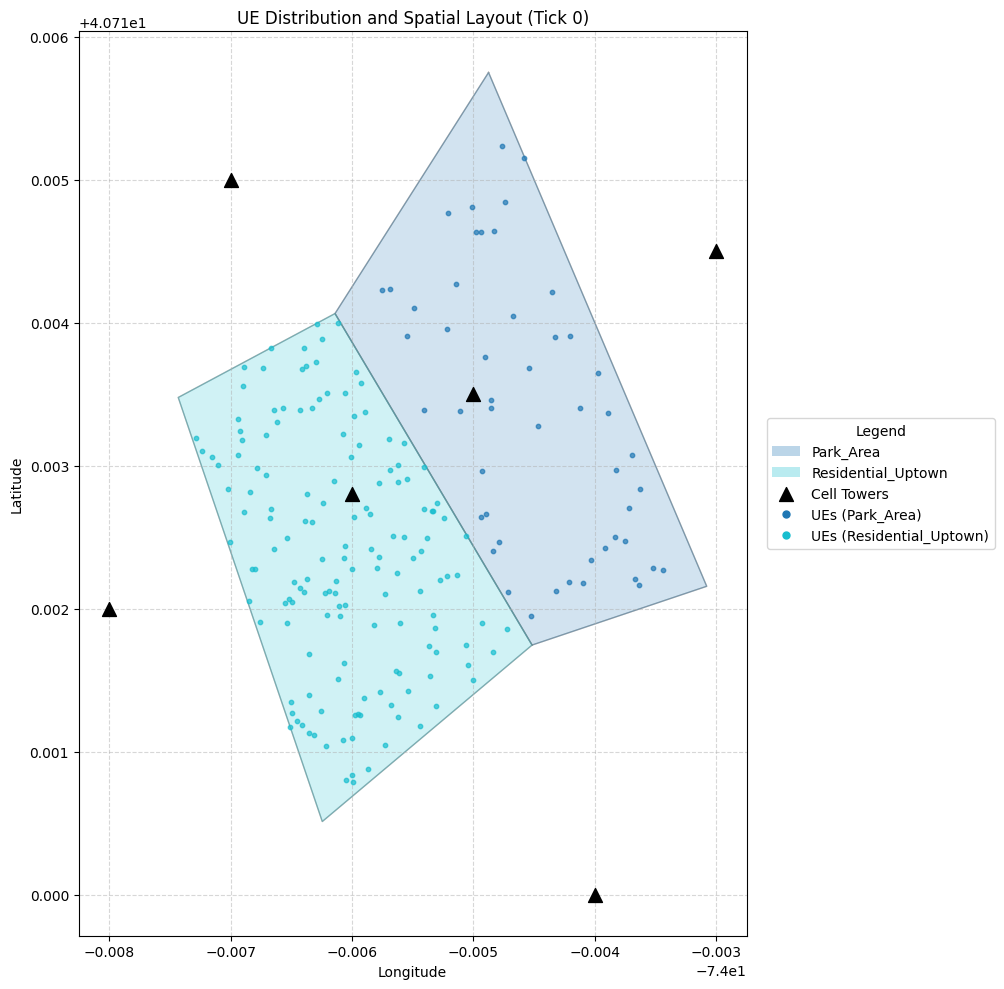

In [14]:
from shapely.geometry import Polygon as ShapelyPolygon # Avoid conflict if Polygon is used elsewhere
from matplotlib.patches import Patch as MatplotlibPatch

tick_to_plot = 0 # Choose a tick to visualize

if tick_to_plot in ue_data_per_tick_output and not ue_data_per_tick_output[tick_to_plot].empty:
    ue_df_plot = ue_data_per_tick_output[tick_to_plot]
    
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # 1. Plot Spatial Layout Polygons
    spatial_types_in_layout = sorted(list(set(cell['type'] for cell in spatial_layout_output)))
    cmap_spaces = plt.get_cmap('tab10', len(spatial_types_in_layout))
    space_colors = {stype: cmap_spaces(i) for i, stype in enumerate(spatial_types_in_layout)}
    legend_patches_spatial = []

    for cell_info in spatial_layout_output:
        poly_coords = cell_info['bounds']
        poly_type = cell_info['type']
        polygon = ShapelyPolygon(poly_coords)
        ax.plot(*polygon.exterior.xy, color='gray', alpha=0.7, linewidth=1, zorder=1) # Plot boundary
        ax.fill(*polygon.exterior.xy, color=space_colors.get(poly_type, 'lightgray'), alpha=0.2, zorder=1) # Fill area
        
        # Add to legend only once per type
        if not any(p.get_label() == poly_type.title() for p in legend_patches_spatial):
            legend_patches_spatial.append(MatplotlibPatch(facecolor=space_colors.get(poly_type, 'lightgray'), 
                                                          alpha=0.3, label=poly_type.title()))
            
    # 2. Plot Cell Towers
    ax.scatter(topology_df[COL_CELL_LON], topology_df[COL_CELL_LAT],
               marker='^', c='black', s=100, label='Cell Towers', zorder=3)
    
    # 3. Plot UEs for the selected tick
    # Color UEs by their 'space_type' for this demo
    legend_patches_ue = []
    plotted_ue_types_legend = set()

    if 'space_type' in ue_df_plot.columns:
        for ue_space_type, group_df in ue_df_plot.groupby('space_type'):
            ax.scatter(group_df[COL_LON_NAME], group_df[COL_LAT_NAME], 
                       s=10, alpha=0.7, label=f'UEs ({ue_space_type})', 
                       color=space_colors.get(ue_space_type, 'blue'), zorder=2)
            if ue_space_type not in plotted_ue_types_legend:
                 legend_patches_ue.append(plt.Line2D([0], [0], marker='o', 
                                                    color=space_colors.get(ue_space_type, 'blue'), 
                                                    linestyle='', ms=5, label=f'UEs ({ue_space_type.title()})'))
                 plotted_ue_types_legend.add(ue_space_type)
    else: # Fallback if no space_type column
        ax.scatter(ue_df_plot[COL_LON_NAME], ue_df_plot[COL_LAT_NAME], s=10, alpha=0.6, label='UEs', zorder=2)
        legend_patches_ue.append(plt.Line2D([0], [0], marker='o', color='blue', linestyle='', ms=5, label='UEs'))
        
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_title(f"UE Distribution and Spatial Layout (Tick {tick_to_plot})")
    
    # Combine legends
    all_legend_handles = [p for p in legend_patches_spatial] + [ax.collections[0]] + [p for p in legend_patches_ue]
    # Filter out None if any legend element was not created
    all_legend_handles = [h for h in all_legend_handles if h is not None]
    
    # Create legend outside plot area
    ax.legend(handles=all_legend_handles, loc='center left', bbox_to_anchor=(1.02, 0.5), title="Legend")
    
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to make space for legend
    plt.show()
else:
    logger.warning(f"No UE data found for tick {tick_to_plot}, or spatial layout is empty. Cannot generate plot.")

## 6. Conclusion

This notebook demonstrated the basic workflow of using `TrafficDemandModel` to generate synthetic UE data. The model creates a fixed spatial representation of different area types based on Voronoi regions of cell towers and then populates these areas with UEs over several time ticks according to specified density profiles.

The outputs (`ue_data_per_tick_output` and `spatial_layout_output`) can be used as inputs for further network simulations, CCO algorithm testing, or RL environment interactions.